In [3]:
pip install pyspark

     |████████████████████████████████| 281.3 MB 40 kB/s 
     |████████████████████████████████| 198 kB 52.0 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805911 sha256=8b7586675f4203e5e3e1adc7e55897b909954ad3760271f921d2a7667875e253
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Hide warnings
import warnings
warnings.filterwarnings('ignore')

**Import modules pyspark and create spark session**

In [5]:
#import modules
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql import SparkSession
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import HashingTF, Tokenizer, StopWordsRemover

#create Spark session
appName = "Sentiment Analysis on Tweets about COVID 19 in Spark"
spark = SparkSession \
    .builder \
    .appName(appName) \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

**Read data file into pandas dataFrame**

In [6]:
tweet_csv = pd.read_csv('/content/drive/MyDrive/covid19_tweets_v2.csv')

**Preview**

In [7]:
tweet_csv.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin i...,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,If I smelled the scent of hand sanitizers toda...,NaN,Twitter for iPhone,False
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Auth...",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,NaN,Twitter for Android,False
2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Re...,2009-02-28 18:57:41,9275,9525,7254,False,2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump nev...,['COVID19'],Twitter for Android,False
3,ethel mertz,Stuck in the Middle,#Browns #Indians #ClevelandProud #[]_[] #Cavs ...,2019-03-07 01:45:06,197,987,1488,False,2020-07-25 12:27:10,@brookbanktv The one gift #COVID19 has give me...,['COVID19'],Twitter for iPhone,False
4,DIPR-J&K,Jammu and Kashmir,🖊️Official Twitter handle of Department of Inf...,2017-02-12 06:45:15,101009,168,101,False,2020-07-25 12:27:08,25 July : Media Bulletin on Novel #CoronaVirus...,"['CoronaVirusUpdates', 'COVID19']",Twitter for Android,False


**Check Columns**

In [8]:
tweet_csv.columns

Index(['user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'text', 'hashtags', 'source', 'is_retweet'],
      dtype='object')

**Datatype**

In [9]:
tweet_csv.dtypes

user_name           object
user_location       object
user_description    object
user_created        object
user_followers       int64
user_friends         int64
user_favourites      int64
user_verified         bool
date                object
text                object
hashtags            object
source              object
is_retweet            bool
dtype: object

**Text Analysis of tweet**

In [10]:
pip install neattext

     |████████████████████████████████| 114 kB 6.9 MB/s 


**Load Text Cleaning Package**

In [11]:
import neattext.functions as nfx

**Methods/Attrib**

In [12]:
dir(nfx)

['BTC_ADDRESS_REGEX',
 'CURRENCY_REGEX',
 'CURRENCY_SYMB_REGEX',
 'Counter',
 'DATE_REGEX',
 'EMAIL_REGEX',
 'EMOJI_REGEX',
 'HASTAG_REGEX',
 'MASTERCard_REGEX',
 'MD5_SHA_REGEX',
 'MOST_COMMON_PUNCT_REGEX',
 'NUMBERS_REGEX',
 'PHONE_REGEX',
 'PoBOX_REGEX',
 'SPECIAL_CHARACTERS_REGEX',
 'STOPWORDS',
 'STOPWORDS_de',
 'STOPWORDS_en',
 'STOPWORDS_es',
 'STOPWORDS_fr',
 'STOPWORDS_ru',
 'STOPWORDS_yo',
 'STREET_ADDRESS_REGEX',
 'TextFrame',
 'URL_PATTERN',
 'USER_HANDLES_REGEX',
 'VISACard_REGEX',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__generate_text',
 '__loader__',
 '__name__',
 '__numbers_dict',
 '__package__',
 '__spec__',
 '_lex_richness_herdan',
 '_lex_richness_maas_ttr',
 'clean_text',
 'defaultdict',
 'digit2words',
 'extract_btc_address',
 'extract_currencies',
 'extract_currency_symbols',
 'extract_dates',
 'extract_emails',
 'extract_emojis',
 'extract_hashtags',
 'extract_html_tags',
 'extract_mastercard_addr',
 'extract_md5sha',
 'extract_numbers',
 'extr

In [15]:
tweet_csv['text'].iloc[1]

"Hey @Yankees @YankeesPR and @MLB - wouldn't it have made more sense to have the players pay their respects to the A… https://t.co/1QvW0zgyPu"

Noise
*   remove mentions/userhandles
*   remove hashtags
*   urls
*   emojis
*   special char

In [16]:
tweet_csv.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin i...,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,If I smelled the scent of hand sanitizers toda...,NaN,Twitter for iPhone,False
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Auth...",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,NaN,Twitter for Android,False
2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Re...,2009-02-28 18:57:41,9275,9525,7254,False,2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump nev...,['COVID19'],Twitter for Android,False
3,ethel mertz,Stuck in the Middle,#Browns #Indians #ClevelandProud #[]_[] #Cavs ...,2019-03-07 01:45:06,197,987,1488,False,2020-07-25 12:27:10,@brookbanktv The one gift #COVID19 has give me...,['COVID19'],Twitter for iPhone,False
4,DIPR-J&K,Jammu and Kashmir,🖊️Official Twitter handle of Department of Inf...,2017-02-12 06:45:15,101009,168,101,False,2020-07-25 12:27:08,25 July : Media Bulletin on Novel #CoronaVirus...,"['CoronaVirusUpdates', 'COVID19']",Twitter for Android,False


In [17]:
tweet_csv['text'].apply(nfx.extract_hashtags)

0                                      []
1                                      []
2                              [#COVID19]
3                              [#COVID19]
4         [#CoronaVirusUpdates, #COVID19]
                       ...               
179103                       [#WearAMask]
179104                         [#COVID19]
179105                                 []
179106                         [#COVID19]
179107                                 []
Name: text, Length: 179108, dtype: object

In [18]:
tweet_csv['extracted_hashtags'] = tweet_csv['text'].apply(nfx.extract_hashtags)

In [19]:
tweet_csv[['extracted_hashtags','hashtags']]

,extracted_hashtags,hashtags
0,[],NaN
1,[],NaN
2,[#COVID19],['COVID19']
3,[#COVID19],['COVID19']
4,"[#CoronaVirusUpdates, #COVID19]","['CoronaVirusUpdates', 'COVID19']"
...,...,...
179103,[#WearAMask],['WearAMask']
179104,[#COVID19],['COVID19']
179105,[],NaN
179106,[#COVID19],['COVID19']


**Cleaning Text**

In [20]:
## Cleaning Text: remove hashtags
tweet_csv['clean_tweet'] = tweet_csv['text'].apply(nfx.remove_hashtags)

In [21]:
tweet_csv[['text','clean_tweet']]

,text,clean_tweet
0,If I smelled the scent of hand sanitizers toda...,If I smelled the scent of hand sanitizers toda...
1,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,Hey @Yankees @YankeesPR and @MLB - wouldn't it...
2,@diane3443 @wdunlap @realDonaldTrump Trump nev...,@diane3443 @wdunlap @realDonaldTrump Trump nev...
3,@brookbanktv The one gift #COVID19 has give me...,@brookbanktv The one gift has give me is an ...
4,25 July : Media Bulletin on Novel #CoronaVirus...,25 July : Media Bulletin on Novel \n@kansa...
...,...,...
179103,Thanks @IamOhmai for nominating me for the @WH...,Thanks @IamOhmai for nominating me for the @WH...
179104,2020! The year of insanity! Lol! #COVID19 http...,2020! The year of insanity! Lol! https://t.c...
179105,@CTVNews A powerful painting by Juan Lucena. I...,@CTVNews A powerful painting by Juan Lucena. I...
179106,"More than 1,200 students test positive for #CO...","More than 1,200 students test positive for a..."


In [22]:
tweet_csv['clean_tweet'] = tweet_csv['clean_tweet'].apply(lambda x: nfx.remove_userhandles(x))
tweet_csv[['text','clean_tweet']]

,text,clean_tweet
0,If I smelled the scent of hand sanitizers toda...,If I smelled the scent of hand sanitizers toda...
1,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,Hey and - wouldn't it have made more sen...
2,@diane3443 @wdunlap @realDonaldTrump Trump nev...,Trump never once claimed was a hoax. W...
3,@brookbanktv The one gift #COVID19 has give me...,The one gift has give me is an appreciatio...
4,25 July : Media Bulletin on Novel #CoronaVirus...,25 July : Media Bulletin on Novel \n ...
...,...,...
179103,Thanks @IamOhmai for nominating me for the @WH...,Thanks for nominating me for the challen...
179104,2020! The year of insanity! Lol! #COVID19 http...,2020! The year of insanity! Lol! https://t.c...
179105,@CTVNews A powerful painting by Juan Lucena. I...,A powerful painting by Juan Lucena. It's a t...
179106,"More than 1,200 students test positive for #CO...","More than 1,200 students test positive for a..."


In [23]:
tweet_csv['clean_tweet'].iloc[10]

'49K+ Covid19 cases still no response from \n      cancel the compartment exa… https://t.co/kV2ZKmumu1'

In [24]:
# Cleaning Text: Multiple WhiteSpaces
tweet_csv['clean_tweet'] = tweet_csv['clean_tweet'].apply(nfx.remove_multiple_spaces)

In [25]:
tweet_csv['clean_tweet'].iloc[10]

'49K+ Covid19 cases still no response from cancel the compartment exa… https://t.co/kV2ZKmumu1'

In [26]:
# Cleaning Text : Remove urls
tweet_csv['clean_tweet'] = tweet_csv['clean_tweet'].apply(nfx.remove_urls)

In [27]:
# Cleaning Text: Punctuations
tweet_csv['clean_tweet'] = tweet_csv['clean_tweet'].apply(nfx.remove_puncts)

In [28]:
tweet_csv[['text','clean_tweet']]

,text,clean_tweet
0,If I smelled the scent of hand sanitizers toda...,If I smelled the scent of hand sanitizers toda...
1,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,Hey and wouldnt it have made more sense to ha...
2,@diane3443 @wdunlap @realDonaldTrump Trump nev...,Trump never once claimed was a hoax We all cl...
3,@brookbanktv The one gift #COVID19 has give me...,The one gift has give me is an appreciation f...
4,25 July : Media Bulletin on Novel #CoronaVirus...,25 July : Media Bulletin on Novel
...,...,...
179103,Thanks @IamOhmai for nominating me for the @WH...,Thanks for nominating me for the challenge I n...
179104,2020! The year of insanity! Lol! #COVID19 http...,2020 The year of insanity Lol
179105,@CTVNews A powerful painting by Juan Lucena. I...,A powerful painting by Juan Lucena Its a trib...
179106,"More than 1,200 students test positive for #CO...",More than 1200 students test positive for at m...


**Sentiment Analysis**

In [29]:
from textblob import TextBlob

In [30]:
def get_sentiment(text):
    blob = TextBlob(text)
    sentiment_polarity = blob.sentiment.polarity
    sentiment_subjectivity = blob.sentiment.subjectivity
    if sentiment_polarity > 0:
        sentiment_label = 'Positive'
    elif sentiment_polarity < 0:
        sentiment_label = 'Negative'
    else:
        sentiment_label = 'Neutral'
    result = {'polarity':sentiment_polarity,
              'subjectivity':sentiment_subjectivity,
              'sentiment':sentiment_label}
    return result

In [31]:
# Text
ex1 = tweet_csv['clean_tweet'].iloc[0]

In [32]:
get_sentiment(ex1)

{'polarity': -0.25, 'sentiment': 'Negative', 'subjectivity': 0.25}

In [33]:
tweet_csv['sentiment_results'] = tweet_csv['clean_tweet'].apply(get_sentiment)

In [34]:
tweet_csv['sentiment_results']

0         {'polarity': -0.25, 'subjectivity': 0.25, 'sen...
1         {'polarity': 0.5, 'subjectivity': 0.5, 'sentim...
2         {'polarity': 0.0, 'subjectivity': 0.0, 'sentim...
3         {'polarity': 0.0, 'subjectivity': 0.3571428571...
4         {'polarity': 0.0, 'subjectivity': 0.0, 'sentim...
                                ...                        
179103    {'polarity': 0.2, 'subjectivity': 0.2, 'sentim...
179104    {'polarity': 0.8, 'subjectivity': 0.7, 'sentim...
179105    {'polarity': 0.3, 'subjectivity': 1.0, 'sentim...
179106    {'polarity': 0.26325757575757575, 'subjectivit...
179107    {'polarity': 0.0, 'subjectivity': 0.0, 'sentim...
Name: sentiment_results, Length: 179108, dtype: object

In [35]:
tweet_csv['sentiment_results'].iloc[0]

{'polarity': -0.25, 'sentiment': 'Negative', 'subjectivity': 0.25}

In [36]:
pd.json_normalize(tweet_csv['sentiment_results'].iloc[0])

,polarity,subjectivity,sentiment
0,-0.25,0.25,Negative


In [37]:
tweet_csv = tweet_csv.join(pd.json_normalize(tweet_csv['sentiment_results']))

In [38]:
tweet_csv.head(10)

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,extracted_hashtags,clean_tweet,sentiment_results,polarity,subjectivity,sentiment
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin i...,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,If I smelled the scent of hand sanitizers toda...,NaN,Twitter for iPhone,False,[],If I smelled the scent of hand sanitizers toda...,"{'polarity': -0.25, 'subjectivity': 0.25, 'sen...",-0.25,0.250000,Negative
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Auth...",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,NaN,Twitter for Android,False,[],Hey and wouldnt it have made more sense to ha...,"{'polarity': 0.5, 'subjectivity': 0.5, 'sentim...",0.50,0.500000,Positive
2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Re...,2009-02-28 18:57:41,9275,9525,7254,False,2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump nev...,['COVID19'],Twitter for Android,False,[#COVID19],Trump never once claimed was a hoax We all cl...,"{'polarity': 0.0, 'subjectivity': 0.0, 'sentim...",0.00,0.000000,Neutral
3,ethel mertz,Stuck in the Middle,#Browns #Indians #ClevelandProud #[]_[] #Cavs ...,2019-03-07 01:45:06,197,987,1488,False,2020-07-25 12:27:10,@brookbanktv The one gift #COVID19 has give me...,['COVID19'],Twitter for iPhone,False,[#COVID19],The one gift has give me is an appreciation f...,"{'polarity': 0.0, 'subjectivity': 0.3571428571...",0.00,0.357143,Neutral
4,DIPR-J&K,Jammu and Kashmir,🖊️Official Twitter handle of Department of Inf...,2017-02-12 06:45:15,101009,168,101,False,2020-07-25 12:27:08,25 July : Media Bulletin on Novel #CoronaVirus...,"['CoronaVirusUpdates', 'COVID19']",Twitter for Android,False,"[#CoronaVirusUpdates, #COVID19]",25 July : Media Bulletin on Novel,"{'polarity': 0.0, 'subjectivity': 0.0, 'sentim...",0.00,0.000000,Neutral
5,🎹 Franz Schubert,Новоро́ссия,🎼 #Новоро́ссия #Novorossiya #оставайсядома #S...,2018-03-19 16:29:52,1180,1071,1287,False,2020-07-25 12:27:06,#coronavirus #covid19 deaths continue to rise....,"['coronavirus', 'covid19']",Twitter Web App,False,"[#coronavirus, #covid19]",deaths continue to rise Its almost as bad as ...,"{'polarity': -0.6999999999999998, 'subjectivit...",-0.70,0.666667,Negative
6,hr bartender,"Gainesville, FL",Workplace tips and advice served up in a frien...,2008-08-12 18:19:49,79956,54810,3801,False,2020-07-25 12:27:03,How #COVID19 Will Change Work in General (and ...,"['COVID19', 'Recruiting']",Buffer,False,"[#COVID19, #Recruiting…]",How Will Change Work in General (and recruitin...,"{'polarity': 0.05000000000000002, 'subjectivit...",0.05,0.500000,Positive
7,Derbyshire LPC,NaN,NaN,2012-02-03 18:08:10,608,355,95,False,2020-07-25 12:27:00,You now have to wear face coverings when out s...,NaN,TweetDeck,False,[],You now have to wear face coverings when out s...,"{'polarity': 0.0, 'subjectivity': 0.0, 'sentim...",0.00,0.000000,Neutral
8,Prathamesh Bendre,NaN,"A poet, reiki practitioner and a student of law.",2015-04-25 08:15:41,25,29,18,False,2020-07-25 12:26:59,Praying for good health and recovery of @Chouh...,"['covid19', 'covidPositive']",Twitter for Android,False,"[#covid19, #covidPositive]",Praying for good health and recovery of,"{'polarity': 0.7, 'subjectivity': 0.6000000000...",0.70,0.600000,Positive
9,Member of Christ 🇨🇳🇺🇸🇮🇳🇮🇩🇧🇷🇳🇬🇧🇩🇷🇺,👇🏻location at link below👇🏻,"Just as the body is one & has many members, & ...",2014-08-17 04:53:22,55201,34239,29802,False,2020-07-25 12:26:54,POPE AS GOD - Prophet Sadhu Sundar Selvaraj. W...,"['HurricaneHanna', 'COVID19']",Twitter for iPhone,False,"[#HurricaneHanna, #COVID19…]",POPE AS GOD Prophet Sadhu Sundar Selvaraj Wat...,"{'polarity': 0.0, 'subjectivity': 0.0, 'sentim...",0.00,0.000000,Neutral


In [40]:
tweet_csv['sentiment'].value_counts()

Neutral     75490
Positive    74154
Negative    29464
Name: sentiment, dtype: int64

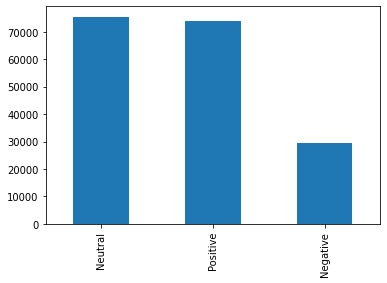

In [41]:
tweet_csv['sentiment'].value_counts().plot(kind='bar')

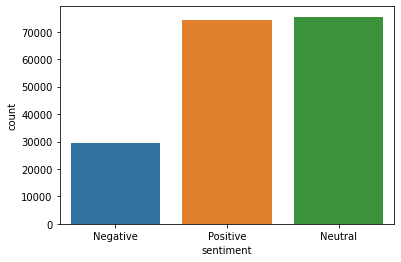

In [42]:
# Plot with seaborn
sns.countplot(tweet_csv['sentiment'])

**extract columns clean_tweet and sentiment**

In [43]:
x=tweet_csv.drop(['user_name','user_location','user_description','user_created','user_followers','user_friends','user_favourites','user_verified','date','text','hashtags','source','is_retweet','extracted_hashtags','sentiment_results','polarity','subjectivity'],axis=1)
x.head(10)

,clean_tweet,sentiment
0,If I smelled the scent of hand sanitizers toda...,Negative
1,Hey and wouldnt it have made more sense to ha...,Positive
2,Trump never once claimed was a hoax We all cl...,Neutral
3,The one gift has give me is an appreciation f...,Neutral
4,25 July : Media Bulletin on Novel,Neutral
5,deaths continue to rise Its almost as bad as ...,Negative
6,How Will Change Work in General (and recruitin...,Positive
7,You now have to wear face coverings when out s...,Neutral
8,Praying for good health and recovery of,Positive
9,POPE AS GOD Prophet Sadhu Sundar Selvaraj Wat...,Neutral


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

**Remove all rows containing neutral values**

In [44]:
neutral_ligne = x[ x['sentiment'] == 'Neutral' ].index
x.drop(neutral_ligne, inplace=True)
print(x)

                                              clean_tweet sentiment
0       If I smelled the scent of hand sanitizers toda...  Negative
1       Hey and  wouldnt it have made more sense to ha...  Positive
5        deaths continue to rise Its almost as bad as ...  Negative
6       How Will Change Work in General (and recruitin...  Positive
8               Praying for good health and recovery of    Positive
...                                                   ...       ...
179096  We were really bummed we couldn’t cop one of t...  Positive
179103  Thanks for nominating me for the challenge I n...  Positive
179104                     2020 The year of insanity Lol   Positive
179105   A powerful painting by Juan Lucena Its a trib...  Positive
179106  More than 1200 students test positive for at m...  Positive

[103618 rows x 2 columns]


Convert sentiment column into 0 and 1

In [45]:
for i in x.index: 
      if(x["sentiment"][i] == "Negative"):
            x["sentiment"][i]= 0
      else:
            x["sentiment"][i]= 1

In [46]:
x

,clean_tweet,sentiment
0,If I smelled the scent of hand sanitizers toda...,0
1,Hey and wouldnt it have made more sense to ha...,1
5,deaths continue to rise Its almost as bad as ...,0
6,How Will Change Work in General (and recruitin...,1
8,Praying for good health and recovery of,1
...,...,...
179096,We were really bummed we couldn’t cop one of t...,1
179103,Thanks for nominating me for the challenge I n...,1
179104,2020 The year of insanity Lol,1
179105,A powerful painting by Juan Lucena Its a trib...,1


**Convert pandas dataframe on spark dataframe**

In [47]:
spark.conf.set("spark.sql.execution.arrow.enabled","true")
sparkDF=spark.createDataFrame(x) 
sparkDF.show(10)

+--------------------+---------+
|         clean_tweet|sentiment|
+--------------------+---------+
|If I smelled the ...|        0|
|Hey and  wouldnt ...|        1|
| deaths continue ...|        0|
|How Will Change W...|        1|
|Praying for good ...|        1|
|👋🏻 — no one wil...|        1|
|Lets all protect ...|        1|
|Second wave of in...|        1|
|COVID Update: The...|        1|
| Good Patriots\nC...|        1|
+--------------------+---------+
only showing top 10 rows



**Select the related data**

In [48]:
#select only "clean_tweet" and "sentiment" column, 
#and cast "Sentiment" column data into integer
data = sparkDF.select("clean_tweet", col("sentiment").cast("Int").alias("label"))
data.show(truncate = False,n=5)

+--------------------------------------------------------------------------------------------------------------------+-----+
|clean_tweet                                                                                                         |label|
+--------------------------------------------------------------------------------------------------------------------+-----+
|If I smelled the scent of hand sanitizers today on someone in the past I would think they were so intoxicated that… |0    |
|Hey and  wouldnt it have made more sense to have the players pay their respects to the A…                           |1    |
| deaths continue to rise Its almost as bad as it ever was Politicians and businesses want…                          |0    |
|How Will Change Work in General (and recruiting specifically) via/                                                  |1    |
|Praying for good health and recovery of                                                                             |1    |


**Divide data into training and testing data**

In [49]:
#divide data, 70% for training, 30% for testing
dividedData = data.randomSplit([0.7, 0.3]) 
trainingData = dividedData[0] #index 0 = data training
testingData = dividedData[1] #index 1 = data testing
train_rows = trainingData.count()
test_rows = testingData.count()
print ("Training data rows:", train_rows, "; Testing data rows:", test_rows)

Training data rows: 72559 ; Testing data rows: 31059


**Prepare training data**
Separate "clean_tweet" into individual words using tokenizer

In [50]:
tokenizer = Tokenizer(inputCol="clean_tweet", outputCol="SentimentWords")
tokenizedTrain = tokenizer.transform(trainingData)
tokenizedTrain.show(truncate=False, n=10)

+-------------------------------------------------------------------------------------------------------------------+-----+---------------------------------------------------------------------------------------------------------------------------------------+
|clean_tweet                                                                                                        |label|SentimentWords                                                                                                                         |
+-------------------------------------------------------------------------------------------------------------------+-----+---------------------------------------------------------------------------------------------------------------------------------------+
|\n\nفارسی در انتهای پست This is my wife’s new brand: Saayda is about the healthy way of breathing Its o…           |1    |[, , فارسی, در, انتهای, پست, this, is, my, wife’s, new, brand:, saayda, is, about, the, healthy, 

**Removing stop words (unimportant words to be features)**

In [51]:
swr = StopWordsRemover(inputCol=tokenizer.getOutputCol(), 
                       outputCol="MeaningfulWords")
SwRemovedTrain = swr.transform(tokenizedTrain)
SwRemovedTrain.show(truncate=False, n=10)

+-------------------------------------------------------------------------------------------------------------------+-----+---------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------+
|clean_tweet                                                                                                        |label|SentimentWords                                                                                                                         |MeaningfulWords                                                                                            |
+-------------------------------------------------------------------------------------------------------------------+-----+---------------------------------------------------------------------------------------------------------------------------------------+-----

**Converting words feature into numerical feature. In Spark 2.2.1,it is implemented in HashingTF funtion using Austin Appleby's MurmurHash 3 algorithm**

In [52]:
hashTF = HashingTF(inputCol=swr.getOutputCol(), outputCol="features")
numericTrainData = hashTF.transform(SwRemovedTrain).select(
    'label', 'MeaningfulWords', 'features')
numericTrainData.show(truncate=False, n=10)

+-----+-----------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|label|MeaningfulWords                                                                                            |features                                                                                                                                                                |
+-----+-----------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|1    |[, , فارسی, در, انتهای, پست, wife’s, new, brand:, saayda, healthy, way, breathing, o…]                     |(262144,[51471,89833,112688,11

**Train our classifier model using training data**

In [53]:
lr = LogisticRegression(labelCol="label", featuresCol="features", 
                        maxIter=10, regParam=0.01)
model = lr.fit(numericTrainData)
print ("Training is done!")

Training is done!


**Prepare testing data**

In [54]:
tokenizedTest = tokenizer.transform(testingData)
SwRemovedTest = swr.transform(tokenizedTest)
numericTest = hashTF.transform(SwRemovedTest).select(
    'Label', 'MeaningfulWords', 'features')
numericTest.show(truncate=False, n=10)

+-----+-----------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Label|MeaningfulWords                                                                                |features                                                                                                                                                      |
+-----+-----------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------+
|0    |[, 19, dead, due, virus, texas, nursing, hometexas, wednesday reported, 236, new, coronavirus…]|(262144,[10562,11275,29296,43581,60824,89833,92009,155537,213153,242275,249180,255329],[1.0,1.0,1.0,1.0,1.0,

**Predict testing data and calculate the accuracy model**

In [55]:
prediction = model.transform(numericTest)
predictionFinal = prediction.select(
    "MeaningfulWords", "prediction", "Label")
predictionFinal.show(n=4, truncate = False)
correctPrediction = predictionFinal.filter(
    predictionFinal['prediction'] == predictionFinal['Label']).count()
totalData = predictionFinal.count()
print("correct prediction:", correctPrediction, ", total data:", totalData, 
      ", accuracy:", correctPrediction/totalData)

+-----------------------------------------------------------------------------------------------+----------+-----+
|MeaningfulWords                                                                                |prediction|Label|
+-----------------------------------------------------------------------------------------------+----------+-----+
|[, 19, dead, due, virus, texas, nursing, hometexas, wednesday reported, 236, new, coronavirus…]|1.0       |0    |
|[, 751/x, 🇮🇷, reinfection, reports, iran:, , per, report, isna, ali, larija…]                |1.0       |1    |
|[, 2, year, old, child, raped, isolation, covid19, race, disputes, capture, minds…]            |1.0       |1    |
|[, tremendously, popular, program, allows, free, access, clinical, psychologist, during…]      |1.0       |1    |
+-----------------------------------------------------------------------------------------------+----------+-----+
only showing top 4 rows

correct prediction: 27163 , total data: 31059 , accuracy: